# Deep Q-Networks

Assumptions and limitations of the value-iteration method 

On every step, the value iteration method does a loop on all states, and for every state, it performs an update of its value using the Bellman approximation.

The Q-values is almost the same but we approximate and store values for every state and action. 

1. Is the count of the environemnet states and our ability to iterate over them. In value iteration, we assume that we know all states in our environment in advance, can iterate over them, and can store value approximations associated with them. It is true for a simple example but what about much more complex ones? An example with the Atari 2600 game with a resolution of 210x160 pixels and every pixel has one of 128 colors. So every frame of the screen has 33600 pixels and the total number of different screens possible is 128^33600. If we decide to enumerate over all possible states in the Atari game it will take billions of years to do so. 

2. Another problem with the value iteration method is that it limits us to discrete action spaces. Both value of state and the value of the action approximations assume that our actions are a mutually exclusive discrete set, which is not true for continuous variables such as the angle of a steering wheel etc. 

# Tabular Learning 

Do we really need to iterate over every state in the state space? If some state in the state space is not shown to us by the environment, why should we care about its value? We can use states obtained from the environement to update the values of the state, which can save us a lot of work. 

This modification of the value iteration method is known as *Q-Learning*. 

1. Start with an empty table, mapping states to values of actions.

2. By interacting with the environement obtain the tuple *s,a r, s•*(state, action, reward and the new state). In this step you need to decide which action to take and there is not right or wrong action to take. 

3. Update the *Q(s,a)* value using the Bellman approximation

\begin{equation}
Q(s, a) \leftarrow r+\gamma \max _{a^{\prime} \in A} Q\left(s^{\prime}, a^{\prime}\right)
\end{equation}

4. Repeat from Step 2

As in value iteration, the end condition could be some threshold of the update, or we could perform test episodes to esitmate the expected reward from the policy.

#### How do we update the Q-values?
As we take samples from the environment, it's generally a bad idea to just assign new values on top of existing values, as training can become unstable..

Instead use a "blending" technique where we average the approximations between the new values and the old values using a parameter, alpha which is the learning rate of a value from 0 to 1.

\begin{equation}
Q(s, a) \leftarrow(1-\alpha) Q(s, a)+\alpha\left(r+\gamma \max _{a^{\prime} \in A} Q\left(s^{\prime}, a^{\prime}\right)\right)
\end{equation}


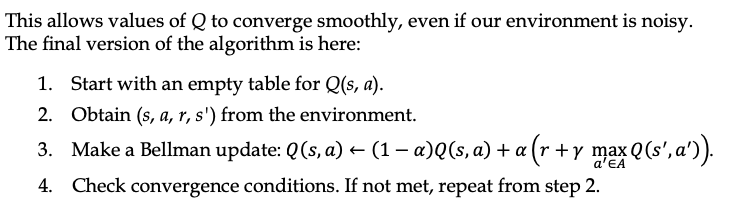




# Deep Q-learning

One solution to overcome the issues from having having an infinite amount of states in the environment is to use a nonlinear representation that maps both the state and action onto a value or in machine learning this is known as a regression problem. We can make some changes to the Q-learning example with the following:

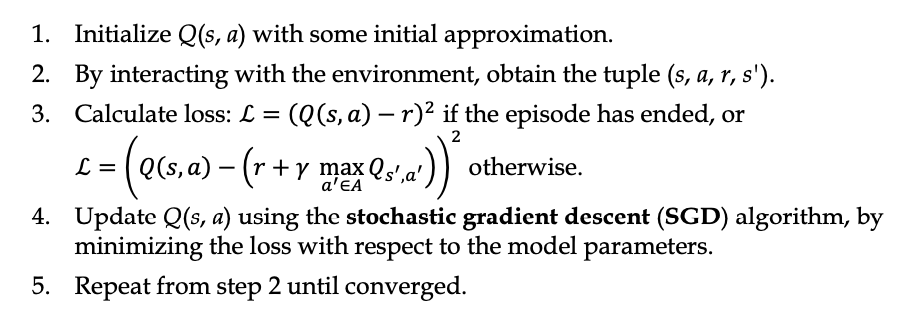

The preceeding algorithm looks simple but unfortunately will not work very well.

Here is why.

## Interaction with the environment

First we need to interact with the environment to get any data to train on. In simple environments we can just act randomly and that will be sufficient but what about more difficult environments where taking a random action might not be the best option and could result in the agent taking a long time waiting for it to guess the best action as the probability of the action that the agent takes being the best one is very low but not 0. 

As an alternative we can use the Q-function approximation as a source of behavior where in the value iteration method we remembered the experience gained by the agent to use during testing. 

If the representation of the Q values is good then the agent will be making good actions that can be used to train on but if the agent does not take good actions then it would be stuck at making bad actions for some states without ever trying to behave differently. 

On one hand the agent should explore the environment to build a complete picture of transitions and action outcomes but on the other hand the agent should use the interactions with the environment efficiently by wasting time trying out action that have already been tried and the learned outcomes that come with them.

Random behavior during the start of the training when the Q approximation is bad as it gives us more uniformly distributed information about the environment states but as the training progresses random behavior becomes inefficient and we should then fall back to the Q approximation to decide how to act. 

A method that combines both together is the **epsilon-greedy method** which just switches between the random and Q policy using the probability hyperparameter epsilon. By varying epsilon we can select the ratio of random actions. With epsilon = 1.0 it would be completely random actions and with lower epsilon values it would be less random actions. 






## SGD optimization

The core of this problem is that we are trying to approximate a complex nonlinear function Q(s,a) with an NN. But one of the most fundemantal requirements for SGD is that the data is independent and identically distributed but our data is not:

1. Our samples are not independent. Even if we accumulate a large batch of data samples, they will all be very close to each other, as they will belong to the same episode. 

2. Distribution of our training data won't be identical to samples provided byu the optimal policy that we want to learn. Data that we have will be a result of some other policy (our current policy, random, or both in the case of epsilon-greedy), but we don't want to learn how to play randomly: we want an optimal policy with the best reward.

We need a large buffer of our past experience and sample training data from it, instead of using our latest experience. 

This is called the **replay buffer** where we have a buffer of fixed size with new data added to the end of the buffer so that it pushes the oldest experienve out of it. Replay buffer allows us to train on more-or-less independent data, but the data will still be fresh enough to train on samples generated by our recent policy. In the next chapter, we will check another kind of replay buffer: prioritized, which provides a more sophisticated sampling approach.


## Correlation between steps

Another issue relating to the data not being independent and identically distributed. The Bellman equation provides us with the Q values of a state and the next state. However there is only a single step between the states and makes them quite similar to one another. This also makes it harder for a NN to distinguish between them. With an update to the Q values of a particular state we could also indirectly update the values of the next state as well. This makes the training process highly unstable.

To make training more stable, there is a trick, called target network, by which we keep a copy of our network and use it for the Q(s', a') value in the Bellman equation. This network is synchronized with our main network only periodically, for example, once in N steps (where N is usually quite a large hyperparameter, such as 1k or 10k training iterations).

## The Markov property

The RL methods we use all work on the basis of the Markov Decision process as their basis which assumes that the environement obeys the Markov Property where the observations from the environement allow us to distinguish states from one another. 

With the Pong example one single image is not enough to capture all the important information which makes it violate the Markov property and moves the single-frame pong environment into the **partially observable Markov Desicion Processes**. 

A POMDP is basically a MDP without the Markov Property. For example, for most card games in which you don't see your opponents' cards, game observations are POMDPs, because the current observation (your cards and cards on the table) could correspond to different cards in your opponents' hands.

The solution is maintaining several observations from the past and using them as a state. In the case of Atari games, we usually stack k subsequent frames together and use them as the observation at every state. This allows our agent to deduct the dynamics of the current state, for instance, to get the speed of the ball and its direction. The usual "classical" number of k for Atari is four. Of course, it's just a hack, as there can be longer dependencies in the environment, but for most of the games, it works well.

## Final form of DQN training 

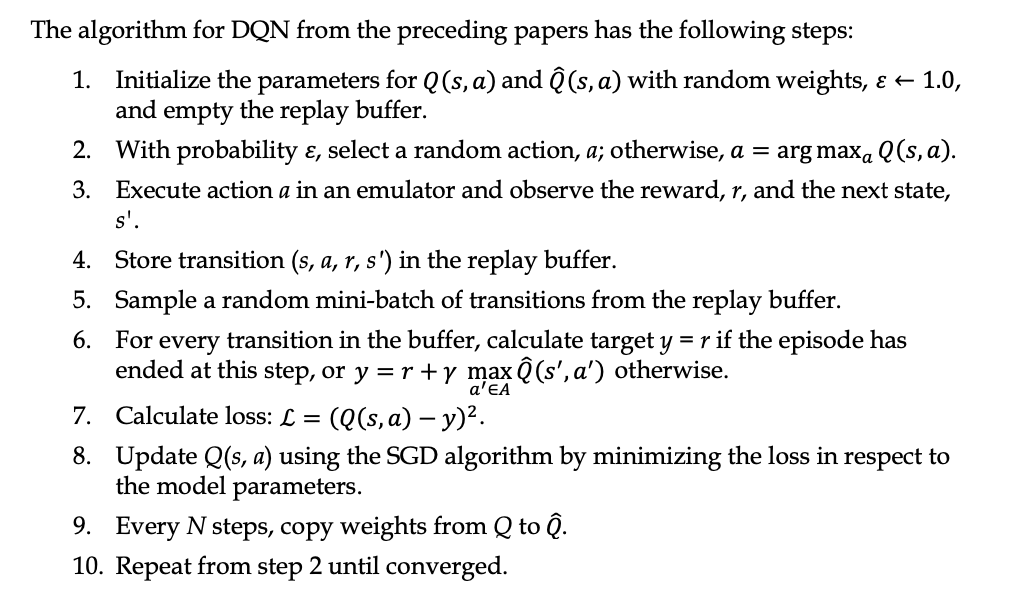